<a href="https://colab.research.google.com/github/Gauravhulmukh/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from scipy import stats

from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input,Dense
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


**Loading the data**

The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.



In [5]:
df=pd.read_csv("creditcard.csv")
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [6]:
df.shape

(17918, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [7]:
df.isnull().values.any()

True

0.0    17836
1.0       81
Name: Class, dtype: int64

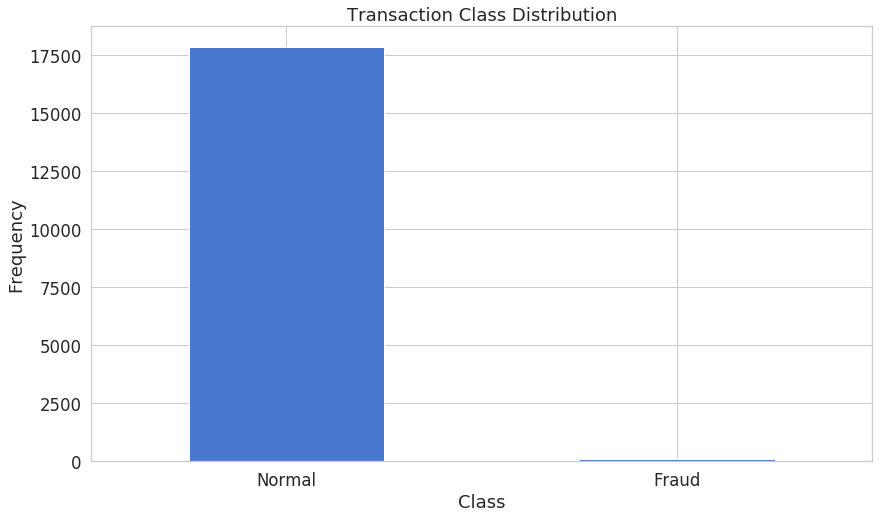

In [8]:
count_classes = pd.value_counts(df['Class'])
count_classes.plot(kind = 'bar',rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes

In [0]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]


In [10]:
print(frauds.shape)
print(normal.shape)
print(frauds.Amount.describe())
print(normal.Amount.describe())

(81, 31)
(17836, 31)
count      81.000000
mean       98.105926
std       267.464067
min         0.000000
25%         1.000000
50%         1.000000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64
count    17836.000000
mean        67.365025
std        188.754429
min          0.000000
25%          5.490000
50%         15.950000
75%         56.232500
max       7712.430000
Name: Amount, dtype: float64


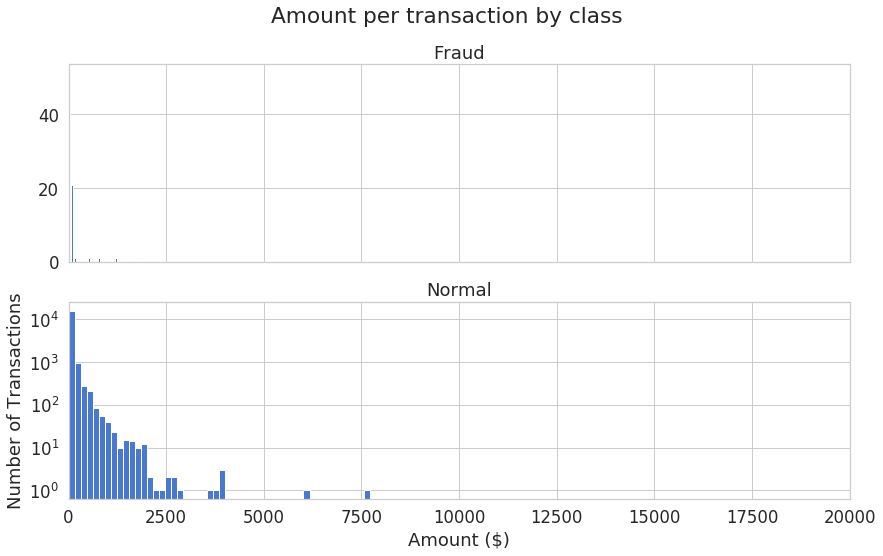

In [11]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle("Amount per transaction by class")
bins = 50

ax1.hist(frauds.Amount,bins =bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount,bins =bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();


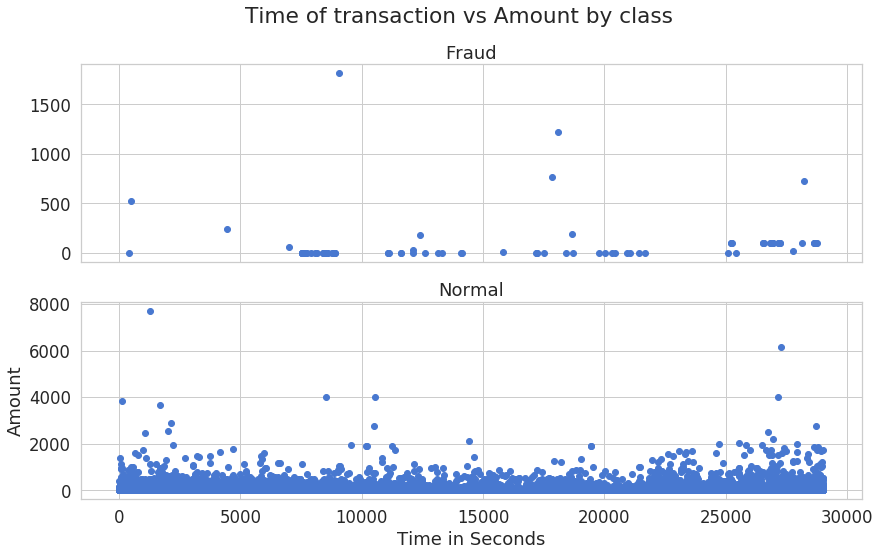

In [12]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction vs Amount by class')


ax1.scatter(frauds.Time,frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time in Seconds')
plt.ylabel('Amount')
plt.show();

**Autoencoders**

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$
While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.

Here's a visual representation of what an Autoencoder might learn:



**Reconstruction error**

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$
If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

**Preparing the data**

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [0]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'],axis=1)
#print(data.head())
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
#print(data.head())
#data['Amount'].max()

In [37]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values
X_train.shape


(14270, 29)

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [39]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

W0615 11:38:42.344104 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 11:38:42.391273 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 11:38:42.403785 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [40]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

W0615 11:41:54.026513 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0615 11:41:56.167655 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0615 11:41:56.282763 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 14270 samples, validate on 3584 samples


W0615 11:41:56.715831 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0615 11:41:56.717226 140516743198592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
14270/14270 [==============================] - 1s 73us/step - loss: 1.0669 - acc: 0.1852 - val_loss: 1.3240 - val_acc: 0.3125
Epoch 2/100
14270/14270 [==============================] - 1s 47us/step - loss: 0.9406 - acc: 0.3831 - val_loss: 1.2465 - val_acc: 0.4157
Epoch 3/100
14270/14270 [==============================] - 1s 46us/step - loss: 0.8724 - acc: 0.5064 - val_loss: 1.1913 - val_acc: 0.5491
Epoch 4/100
14270/14270 [==============================] - 1s 41us/step - loss: 0.8368 - acc: 0.5763 - val_loss: 1.1602 - val_acc: 0.5971
Epoch 5/100
14270/14270 [==============================] - 1s 42us/step - loss: 0.8128 - acc: 0.6204 - val_loss: 1.1399 - val_acc: 0.6200
Epoch 6/100
14270/14270 [==============================] - 1s 41us/step - loss: 0.7941 - acc: 0.6486 - val_loss: 1.1211 - val_acc: 0.6454
Epoch 7/100
14270/14270 [==============================] - 1s 41us/step - loss: 0.7801 - acc: 0.6642 - val_loss: 1.1100 - val_acc: 0.6582
Epoch 8/100
14270/14270 [=========

In [42]:
autoencoder = load_model('model.h5')
autoencoder

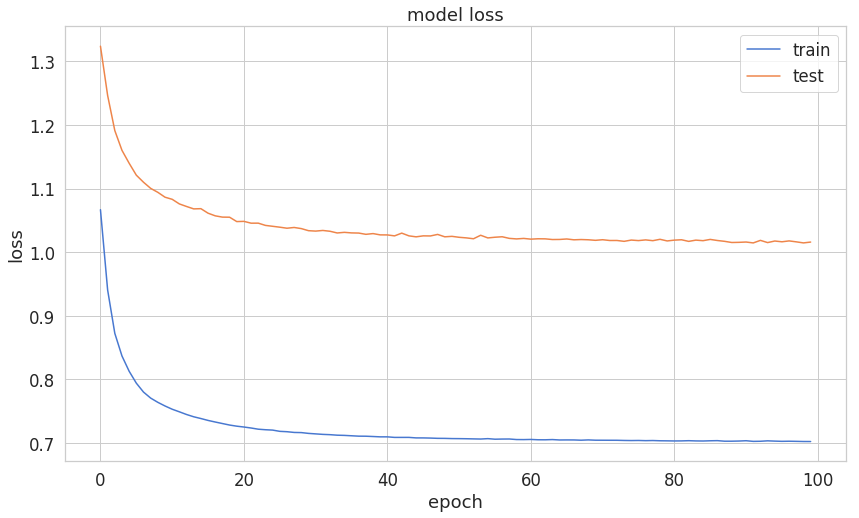

In [43]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [46]:
error_df.describe()

,reconstruction_error,true_class
count,3584.000000,3584.000000
mean,1.008942,0.005022
std,5.783406,0.070700
min,0.043892,0.000000
25%,0.263475,0.000000
50%,0.412258,0.000000
75%,0.647993,0.000000
max,155.036445,1.000000


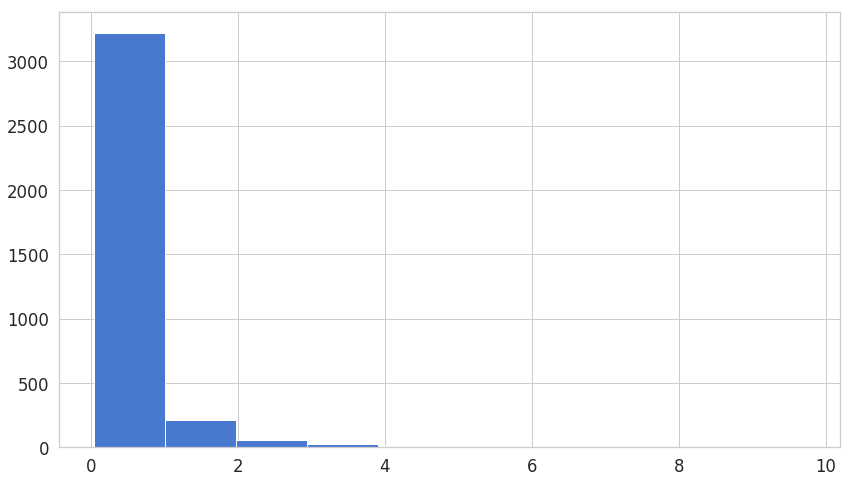

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

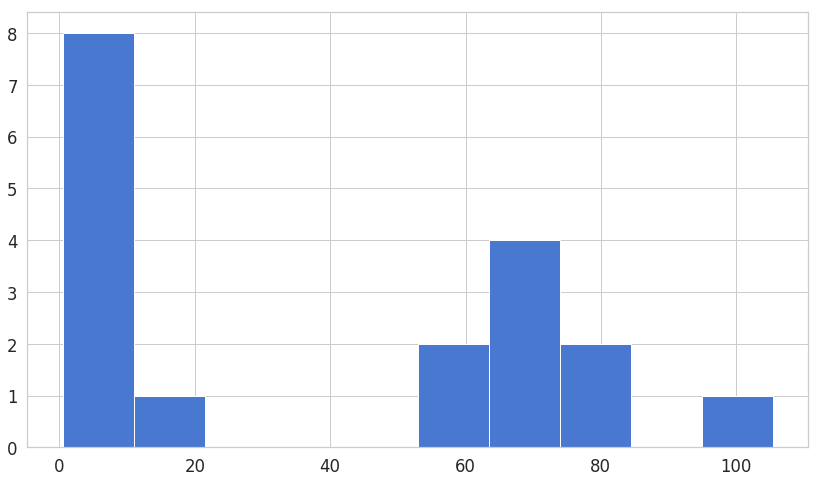

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)


In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

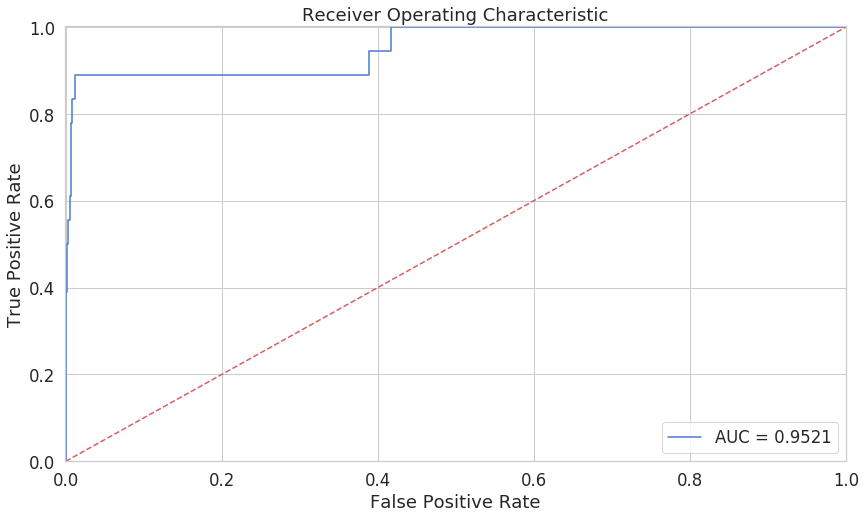

In [50]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

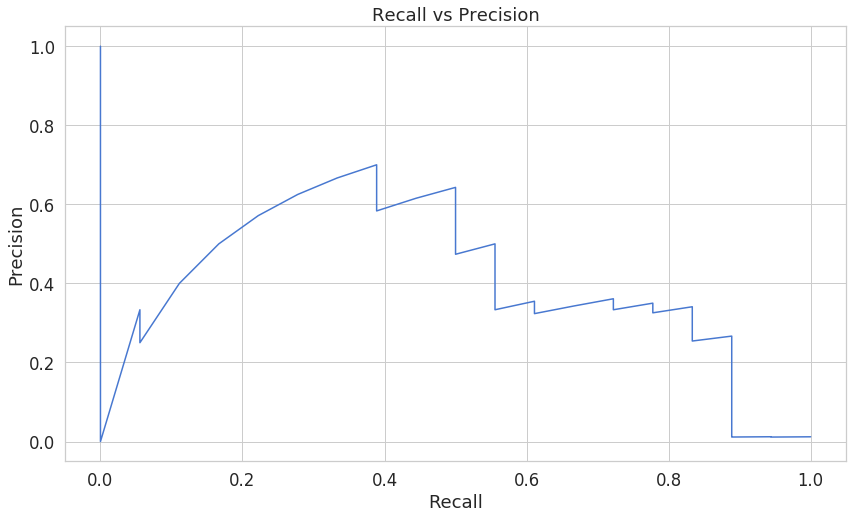

In [51]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

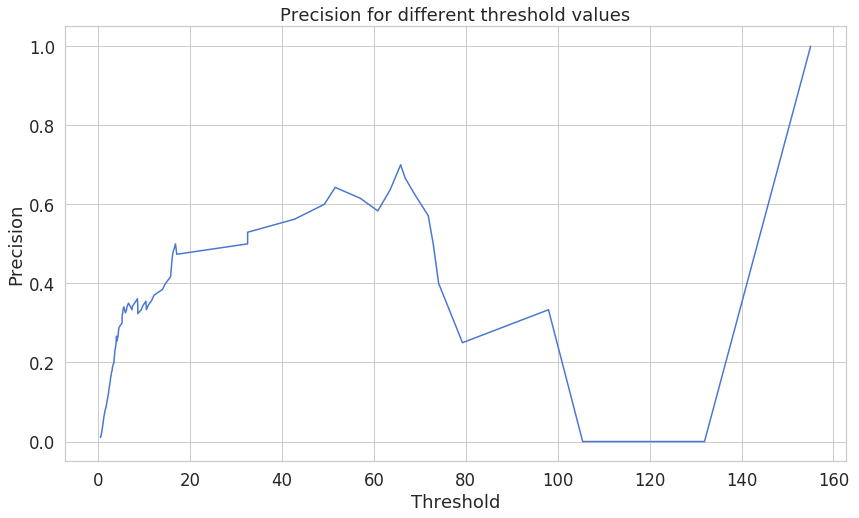

In [52]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

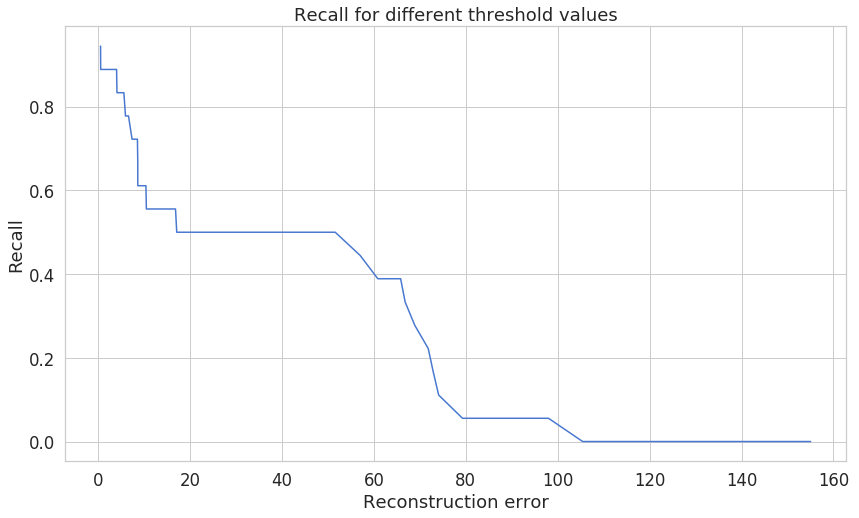

In [53]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [0]:
threshold = 3

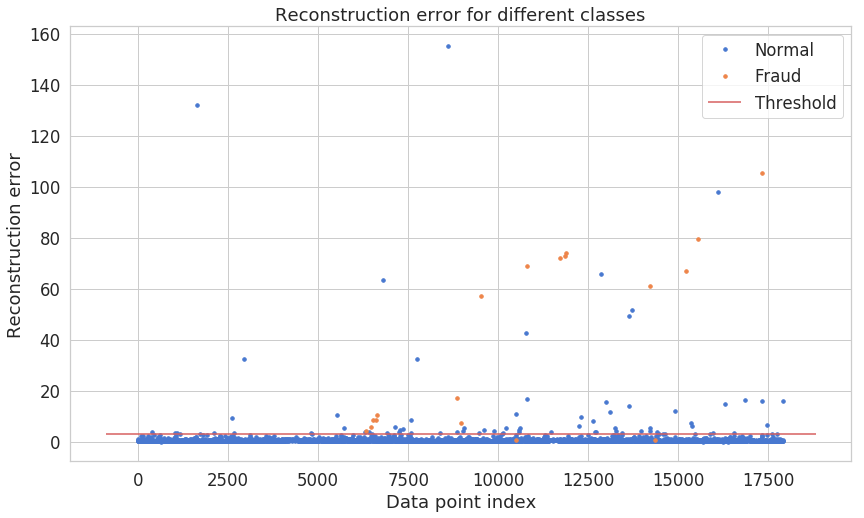

In [60]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


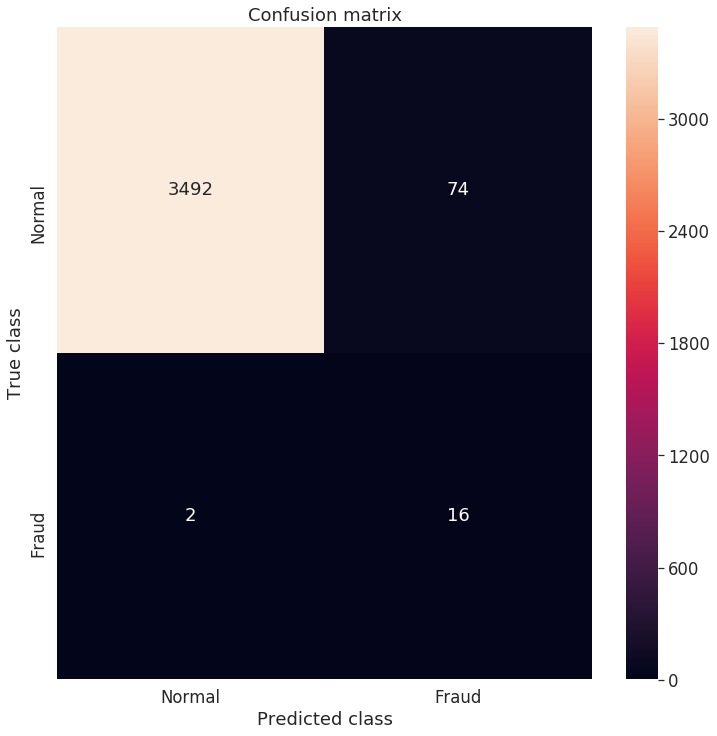

In [61]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()